In [1]:
import os, warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np

import xarray as xr
import rioxarray as rio
import geopandas as gpd
from osgeo import gdal

from xrspatial import zonal_stats
import rasterio

In [2]:
folder = '../../data/ThermalComfort/' #preferred folder path
os.chdir(folder)

In [3]:
aoi = 'capetown' #name of Area of Interest (AOI)

In [4]:
def get_crs(file_path, data_type = 'vector'):
    
    '''
    file_path: Path to geojson or TIFF of the file for which CRS information is required.
    data_type: Type of data. It can be either 'vector' or 'raster'. default is 'vector'.
    '''
    
    if data_type == 'vector':
        gdf = gpd.read_file(file_path)
        crs = str(gdf.crs).upper()
        gdf = None
        return crs
    
    elif data_type == 'raster':
        ds = rasterio.open(file_path)
        crs = str(ds.crs)
        ds = None
        return crs
    
    else: print("Input a valid 'data_type'. Either 'vector' or 'raster'. Default is 'vector'.")

In [5]:
def change_crs(file_path, crs, data_type = 'vector' ):
    
    '''
    file_path: Path to geojson or TIFF for which CRS is to be changed.
    crs: CRS in which file is to be changed. 
    data_type: Type of data. It can be either 'vector' or 'raster'. default is 'vector'.
    '''
    
    if data_type == 'vector':
        
        if crs != get_crs(file_path, data_type = 'vector'):
            gdf = gpd.read_file(file_path)
            gdf = gdf.to_crs(crs)
        else:
            gdf = gpd.read_file(file_path)
        
        return gdf
    
    elif data_type == 'raster':
        
        if f'temp_change_crs_{file_path}' in os.listdir(): os.remove(f'temp_change_crs_{file_path}')
        
        if crs != get_crs(file_path, data_type = 'raster'):
            reproject = gdal.Warp(f"temp_change_crs_{file_path}", file_path, dstSRS = crs)
            reproject = None
            ds = xr.open_dataset(f"temp_change_crs_{file_path}")
        else:
            ds = xr.open_dataset(file_path)
            
        return ds
    
    else: print("Input a valid 'data_type'. Either 'vector' or 'raster'. Default is 'vector'.")

In [6]:
def get_raster_res(raster_path):
    
    '''
    raster_path: Path to TIFF for which resolution is required.
    '''
  
    ds = gdal.Open(raster_path)
    _, xres, _, _, _, yres  = ds.GetGeoTransform()
    ds = None
    
    return (yres, xres)

In [7]:
def get_raster_shape(raster_path):
    
    '''
    raster_path: Path to TIFF for which shape is required.
    '''
  
    ds = gdal.Open(raster_path)
    ds_shape  = ds.ReadAsArray().shape
    ds = None
    
    return ds_shape

In [8]:
def resmple_raster(raster_path, base_raster_path):
    
    '''
    raster_path: Path to TIFF that is to be resampled.
    base_raster: Path to TIFF based on which the first raster will be resampled.
    '''
    
    if f'temp_resmple_raster_{raster_path}' in os.listdir(): os.remove(f'temp_resmple_raster_{raster_path}')
    
    # Open the two datasets
    ras_ds = rio.open_rasterio(raster_path)
    base_ds = rio.open_rasterio(base_raster_path)

    # Define the resampling parameters
    new_width = base_ds.rio.width
    new_height = base_ds.rio.height
    resampling = rasterio.enums.Resampling.bilinear

    # Resample the first dataset to the new dimensions and resampling method
    ras_resampled = ras_ds.rio.reproject(
        base_ds.rio.crs,
        shape=(new_height, new_width),
        resampling = resampling,
        nodata = -999
    )
    
    ras_resampled = ras_resampled.where(ras_resampled != -999, np.nan)
    
    ras_resampled.rio.to_raster(f'temp_resmple_raster_{raster_path}')
    
    ras_resampled = None

In [9]:
def make_netcdf(file_path_list, base_raster_path):
    
    '''
    file_path_list: List of paths of GeoJSON(s) and TIFF(s) from which a NetCDF is to be made for local storage.
    base_raster_path: Path to the TIFF whose CRS, resolution and shape will be followed for files in the list.
    '''
    
    if base_raster_path in file_path_list: file_path_list.remove(base_raster_path)
    
    base_ds = xr.open_dataset(base_raster_path)
    
    crs = get_crs(base_raster_path, data_type='raster')
        
    for file in file_path_list:
        
        if file.endswith('.geojson'):
            
            gdf = change_crs(file, crs, data_type='vector')
            
            gdf = gdf.reset_index()[['geometry', 'index']]
            gdf['index'] = gdf['index'] + 1
            geom = gdf[['geometry', 'index']].values.tolist()
            
            gdf_ds = rasterio.features.rasterize(geom, out_shape=[base_ds.dims['y'],base_ds.dims['x']], transform=base_ds.rio.transform())
            
            #ds = base_ds.squeeze().copy()
            
            base_ds[file.replace('.geojson','')] = (('y', 'x'), gdf_ds)

            
        elif file.endswith('.tif'):
            
            if crs == get_crs(file, data_type='raster'):
                
                if (get_raster_res(base_raster_path) == get_raster_res(file)) and (get_raster_shape(base_raster_path) != get_raster_shape(file)):
                    
                    resample = resmple_raster(file, base_raster_path)
                    resample = None
                    
                    ds = xr.open_dataset(f'temp_resmple_raster_{file}')
                
                else: ds = xr.open_dataset(file)
                    
            else:
                
                reproject = change_crs(file, crs, data_type='raster')
                reproject = None
                
                if (get_raster_res(base_raster_path) != get_raster_res(f'temp_change_crs_{file}')) and (get_raster_shape(base_raster_path) != get_raster_shape(f'temp_change_crs_{file}')):
                    
                    resample = resmple_raster(f'temp_change_crs_{file}', base_raster_path)
                    resample = None
                    
                    ds = xr.open_dataset(f'temp_resmple_raster_temp_change_crs_{file}')
                    
                
                else:
                    
                    ds = xr.open_dataset(file)
                    
            base_ds[file.replace('.tif','')] = (('y', 'x'), np.array(ds['band_data'])[0])
            
            # we want to replace the above line with the following. but currently unbale to do this because the resampled raster doesnt overlay perfectly
            #base_ds[file.replace('.tif','')] = ds['band_data']
            
            ds = None
    
    base_ds[base_raster_path.replace('.tif','')] = (('y', 'x'), np.array(base_ds['band_data'][0]))
    base_ds['constant'] = (('y', 'x'), np.array(base_ds['band_data'][0])*0)
    
    return base_ds

In [10]:
def calculate_zonalstats(netcdf_path, zones_band, value_band):
    
    '''
    netcdf_path: Path to NetCDF that is storing the data from all variables.
    zones_band: Name of the NetCDF band taken as zone. 
    value_band: Name of the NetCDF band taken as values that are to be summarised.
    
    To get summary statistics of band, input zones_band as 'constant'.
    '''
    
    ds = xr.open_dataset(netcdf_path)
    zs = zonal_stats(ds[zones_band], ds[value_band])
    
    return zs

In [11]:
# input of s3 links instead. currently I don;t have the access to could not do that
vector_zone = make_netcdf(['capetown_aoi.geojson', 'capetown_parks.geojson', 'capetown_parkdissolved.geojson', 'capetown_canopyheight.tif', 'capetown_landcover.tif', 'capetown_shadow.tif', 'capetown_skyview.tif', 'capetown_tmrt.tif'], 'capetown_tmrt.tif')
vector_zone.to_netcdf('vector_zone.nc')
vector_zone = None

In [12]:
# input list of s3 links instead. currently I don;t have the access to could not do that
raster_zone = make_netcdf(['capetown_canopyheight.tif', 'capetown_citycentre_landcover.tif', 'capetown_shadow.tif', 'capetown_skyview.tif', 'capetown_tmrt.tif'], 'capetown_citycentre_landcover.tif')
raster_zone.to_netcdf('raster_zone.nc')
raster_zone = None

In [13]:
vector_zs = calculate_zonalstats('vector_zone.nc', 'capetown_parkdissolved', 'capetown_tmrt')

In [14]:
# parks dissolved zonal stats. zone 0 is for non-park areas. 
#Basically, the areas out of the parks is taken as 0. It will be similar for other layers too.
vector_zs

,zone,mean,max,min,sum,std,var,count
0,0,68.970642,78.789055,31.805239,40798344.0,9.967411,99.349274,591532.0
1,1,59.416996,76.881195,32.326199,1053344.5,10.061627,101.236351,17728.0


In [15]:
raster_zs = calculate_zonalstats('raster_zone.nc', 'capetown_citycentre_landcover', 'capetown_canopyheight')

In [16]:
raster_zs # zonal stats

,zone,mean,max,min,sum,std,var,count
0,1.0,0.913337,169.0,0.0,2869012.0,4.354329,18.960179,3141242.0
1,2.0,0.886147,115.0,0.0,1690543.0,4.280203,18.320138,1907746.0
2,5.0,3.210068,106.0,0.0,2663005.0,9.229964,85.192233,829579.0
3,6.0,0.214873,124.0,0.0,22295.0,2.370960,5.621454,103759.0
4,7.0,0.024455,18.0,0.0,7723.0,0.455854,0.207803,315800.0


In [17]:
# values band's summary stats are calculted by putting 'constant' in zones_band
raster_ss = calculate_zonalstats('raster_zone.nc', 'constant', 'capetown_tmrt') 

In [18]:
raster_ss # summary stats

,zone,mean,max,min,sum,std,var,count
0,0.0,68.690048,78.683701,31.832985,411879520.0,9.217008,84.953232,5996204.0


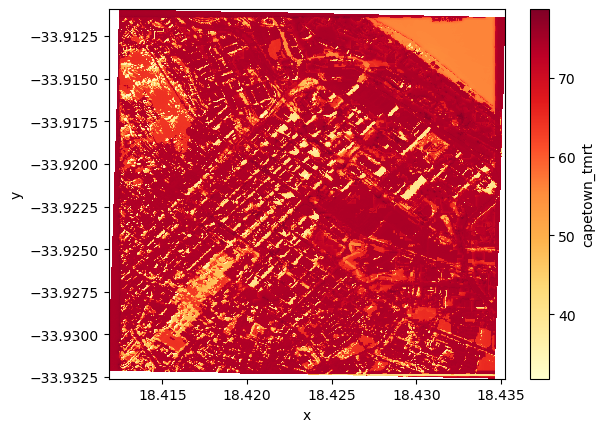

In [19]:
ds = xr.open_dataset('raster_zone.nc')

ds['capetown_tmrt'].plot(cmap = "YlOrRd")

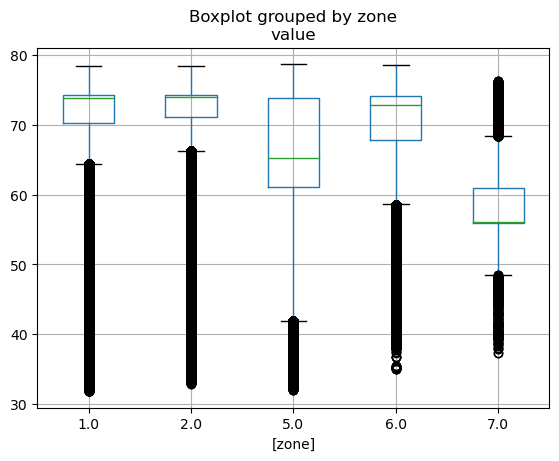

In [20]:
zone = ds['capetown_citycentre_landcover']
df = pd.DataFrame({'value':np.array(ds['capetown_tmrt']).ravel(), 'zone':np.array(ds['capetown_citycentre_landcover']).ravel()})
box_plot = df.boxplot(by='zone')